In [1]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import datetime
# 标准化
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
# 缺失值插补方法
from sklearn.impute import KNNImputer
# 向量单位化
from sklearn.preprocessing import Normalizer
# variance threshold
from sklearn.feature_selection import VarianceThreshold
# f1分数
from sklearn.metrics import f1_score, matthews_corrcoef,precision_score, recall_score
# 随机森林
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB

In [2]:
# 读取数据
df = pd.read_csv('C:/Users/Lenovo/Documents/WeChat Files/wxid_rmt74lhofs1222/FileStorage/File/2022-12/secom.data',sep=' ',header=None)

labels_df = pd.read_csv('C:/Users/Lenovo/Documents/WeChat Files/wxid_rmt74lhofs1222/FileStorage/File/2022-12/secom_labels.data',sep=' ',header=None)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


## 数据分析

In [4]:
df.shape

(1567, 590)

数据项的维度特别高，具有590个特征

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 590 entries, 0 to 589
dtypes: float64(590)
memory usage: 7.1 MB


In [6]:
df.isnull().sum().sort_values(ascending=False)[:50]  #查看空值

157    1429
292    1429
293    1429
158    1429
492    1341
358    1341
85     1341
220    1341
246    1018
109    1018
110    1018
111    1018
518    1018
516    1018
245    1018
244    1018
382    1018
383    1018
384    1018
517    1018
578     949
579     949
580     949
581     949
346     794
73      794
72      794
345     794
112     715
247     715
385     715
519     715
562     273
563     273
564     273
565     273
566     273
567     273
569     273
568     273
555     260
546     260
548     260
549     260
550     260
551     260
552     260
553     260
554     260
547     260
dtype: int64

In [7]:
labels_df

,0,1
0,-1,19/07/2008 11:55:00
1,-1,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00
3,-1,19/07/2008 14:43:00
4,-1,19/07/2008 15:22:00
...,...,...
1562,-1,16/10/2008 15:13:00
1563,-1,16/10/2008 20:49:00
1564,-1,17/10/2008 05:26:00
1565,-1,17/10/2008 06:01:00


In [8]:
labels_df.isnull().sum() 

0    0
1    0
dtype: int64

标签项没有空值

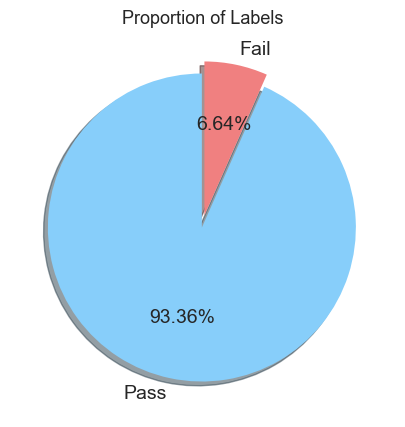

In [9]:
# 设置图大小
plt.figure(figsize=(9, 5))

# 设置图风格
plt.style.use('seaborn-darkgrid')

# 颜色
colors = ['lightskyblue', 'lightcoral']

# 开始画饼状图
plt.pie(labels_df[0].value_counts(), explode=(0.02, 0.06), labels=["Pass", "Fail"], 
        autopct="%0.2f%%", textprops={'fontsize': 14}, shadow=True, startangle=90, colors=colors)
# Pass -> -1
# Fail -> 1

# 添加标题
plt.title('Proportion of Labels', size=13)

plt.show()

可以看出标签只有两类且两类非常不平衡，-1类占了93.36%，对后续的标签预测会有影响，所以在标签预测阶段需要处理标签不平衡问题。

## 数据预处理

###### 1、特征选择

In [10]:
#删除空值数大于900的特征项
df.drop(columns=df.loc[:,df.isna().sum() > 900].columns,inplace=True)
# 删除时间列
labels_df.drop(columns=[1],inplace=True)

In [11]:
df.shape

(1567, 566)

In [12]:
# 将标签转化为1，0(pass->1,fail->0)
labels_df = labels_df.replace(to_replace=[-1, 1], value=[1, 0])


In [13]:
labels_df

,0
0,1
1,1
2,0
3,1
4,1
...,...
1562,1
1563,1
1564,1
1565,1


###### 2、填补空缺值

In [14]:
# KNNImputer从练集中找到最近邻的平均值对缺失值进行估算，如果两个样本都没有丢失的特征很接近，那么这两个样本就是相近的。
imputer = KNNImputer()
df = imputer.fit_transform(df)

In [15]:
df_nona = pd.DataFrame(df)

In [16]:
df_nona.isna().sum()

0      0
1      0
2      0
3      0
4      0
      ..
561    0
562    0
563    0
564    0
565    0
Length: 566, dtype: int64

In [17]:
# 因为数据极度不平衡采用分层抽样划分训练集和测试集
X_train,X_test,Y_train,Y_test=train_test_split(df_nona,labels_df,
                                               test_size=0.25,
                                               random_state=42,
                                               stratify=labels_df)


In [18]:
# 标准化
X_train = pd.DataFrame(StandardScaler().fit_transform(X_train))
X_test = pd.DataFrame(StandardScaler().fit_transform(X_test))
X_test

,0,1,2,3,4,5,6,7,8,9,...,556,557,558,559,560,561,562,563,564,565
0,-2.206237,-0.402069,0.051049,-0.844972,-0.055870,0.0,0.535895,0.114948,0.485111,-0.538054,...,-0.278727,0.112431,-0.943436,-1.041363,-0.933438,-1.031845,1.148652,-0.584902,-0.746381,-0.769996
1,0.825105,-0.958820,0.522543,-0.635766,-0.058830,0.0,-0.158359,-0.029123,0.100437,0.170711,...,-0.244442,0.453994,0.187907,-0.929590,-1.034239,-0.938746,-0.160399,0.251811,-0.023107,-0.043392
2,-0.202223,-1.058060,-0.034815,-0.615810,-0.050270,0.0,0.470182,-0.129972,0.062233,0.542637,...,-0.249637,-0.337620,-0.637668,-0.575641,-0.429433,-0.572700,-0.974360,-0.015937,-0.229757,0.833686
3,-1.405140,0.464158,0.378929,0.804573,-0.056256,0.0,-1.382416,0.021302,0.552297,-0.755596,...,4.059614,3.673334,-0.821129,-0.612899,-0.832637,-0.610052,-2.233062,-0.997680,-1.021914,0.258584
4,0.540598,-1.403311,1.479968,0.851532,-0.051847,0.0,-1.761861,-0.014716,-1.070713,2.409284,...,-0.240967,-0.175955,0.157330,-0.538384,-0.731836,-0.548982,0.578040,-0.662995,-0.815264,-0.709549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,0.254820,-0.067689,-0.605851,-0.661717,-0.049517,0.0,0.553396,0.078930,0.897450,-0.187180,...,-0.227607,-0.038613,1.288674,0.113627,0.477776,0.090384,-0.840098,1.222397,1.010140,1.675814
388,-0.469552,-0.151505,1.273287,-0.335765,-0.049855,0.0,0.367506,0.093337,0.225588,0.198781,...,-0.254800,-0.520162,-1.983049,1.380389,1.888991,1.433549,-0.118442,-0.004781,0.114659,-0.197615
389,0.200870,-0.566414,-0.214144,-0.642634,-0.051510,0.0,0.210544,-0.050733,0.720922,0.177728,...,4.025518,2.759734,-1.799588,0.430317,1.485787,0.466142,0.192038,0.162561,0.321308,-0.276238
390,0.948908,-0.354535,0.998595,0.092881,-0.058971,0.0,0.220363,0.273426,0.479842,-0.032796,...,-0.281013,-0.440047,0.554829,1.380389,1.788190,1.370331,-0.924012,0.374529,0.217984,1.099057


## 逻辑回归

In [19]:
logreg = LogisticRegression(random_state = 42)
Y_pred = logreg.fit(X_train,Y_train).predict(X_test)

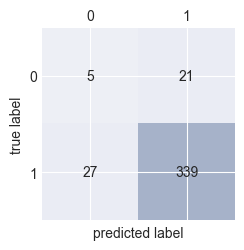

In [20]:
# 混淆矩阵
confmat = confusion_matrix(Y_test,Y_pred)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [21]:
print('precision:%.3f' % precision_score(y_true=Y_test, y_pred=Y_pred,average= 'macro'))
print('recall:%.3f' % recall_score(y_true=Y_test, y_pred=Y_pred,average= 'macro'))
print('F1:%.3f' % f1_score(y_true=Y_test, y_pred=Y_pred,average= 'macro'))

precision:0.549
recall:0.559
F1:0.553


In [22]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred, digits = 3))

              precision    recall  f1-score   support

           0      0.156     0.192     0.172        26
           1      0.942     0.926     0.934       366

    accuracy                          0.878       392
   macro avg      0.549     0.559     0.553       392
weighted avg      0.890     0.878     0.883       392



## 随机生成树

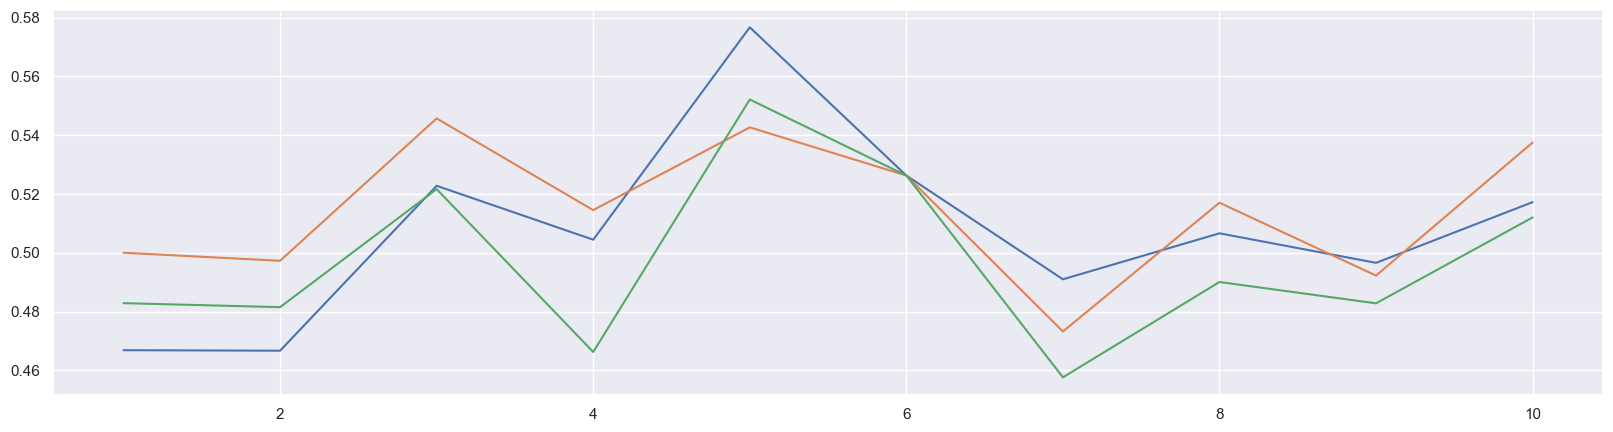

In [51]:
# max_depth学习曲线
precision_list = []
recall_list = []
f1_list = []
for i in range(10):
    rfc = RandomForestClassifier(n_estimators=3, random_state=42, n_jobs=-1, max_depth=i+1)
    Y_pred = rfc.fit(X_train,Y_train).predict(X_test)
    precision_list.append(precision_score(y_true=Y_test, y_pred=Y_pred,average= 'macro'))
    recall_list.append(recall_score(y_true=Y_test, y_pred=Y_pred,average= 'macro'))
    f1_list.append(f1_score(y_true=Y_test, y_pred=Y_pred,average= 'macro'))
plt.figure(figsize=[20,5])
plt.plot(range(1,11),precision_list)
plt.plot(range(1,11),recall_list)
plt.plot(range(1,11),f1_list)
plt.show()

In [37]:
rfc = RandomForestClassifier(n_estimators=3
                             ,random_state=42
                             ,max_depth=5
                             )
Y_pred = rfc.fit(X_train,Y_train).predict(X_test)


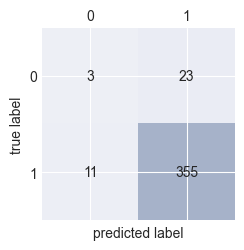

In [41]:
# 混淆矩阵
confmat = confusion_matrix(Y_test,Y_pred)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [39]:
print(classification_report(Y_test, Y_pred, digits = 3))

              precision    recall  f1-score   support

           0      0.214     0.115     0.150        26
           1      0.939     0.970     0.954       366

    accuracy                          0.913       392
   macro avg      0.577     0.543     0.552       392
weighted avg      0.891     0.913     0.901       392



In [40]:
print(f1_score(y_true=Y_test, y_pred=Y_pred,average='macro'))

0.5521505376344086


## 朴素贝叶斯

In [42]:
nbfit = BernoulliNB()
Y_pred = nbfit.fit(X_train, Y_train).predict(X_test)
print(classification_report(Y_test, Y_pred, digits = 3))

              precision    recall  f1-score   support

           0      0.167     0.385     0.233        26
           1      0.952     0.863     0.905       366

    accuracy                          0.832       392
   macro avg      0.559     0.624     0.569       392
weighted avg      0.900     0.832     0.861       392



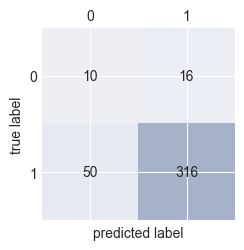

In [43]:
# 混淆矩阵
confmat = confusion_matrix(Y_test,Y_pred)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

## 聚类

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

In [45]:
# 标准化
df_scaled=pd.DataFrame(StandardScaler().fit_transform(df_nona))
df_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,556,557,558,559,560,561,562,563,564,565
0,0.226301,0.849728,-0.437931,0.031923,-0.050123,0.0,-0.559986,0.255040,0.509872,1.128455,...,-0.229797,-0.135520,0.118476,-0.204765,-0.093106,-0.196991,-0.164944,-0.433115,-0.315062,-0.363124
1,1.108313,-0.382754,1.014575,0.151122,-0.059587,0.0,0.200559,0.305366,0.457047,0.022693,...,-0.263493,-0.460054,0.529965,0.406796,0.444803,0.385174,-0.960061,0.412105,0.250318,1.156872
2,-1.110931,0.799112,-0.482920,0.682872,-0.047449,0.0,-0.901749,0.244975,-0.260840,0.327275,...,-0.205046,-0.590505,-1.262951,0.022386,0.014476,0.029952,2.991230,3.627123,3.321515,-0.178909
3,-0.347789,-0.198742,-0.053444,-1.105593,-0.050833,0.0,0.505003,0.003412,0.343268,-0.765245,...,-0.224950,-0.645708,-0.322405,-0.292131,-0.362061,-0.283293,-0.101789,-0.178640,-0.308082,-0.275002
4,0.244118,0.087624,1.114763,-0.160047,-0.047035,0.0,-0.112438,0.184584,0.545089,-0.149461,...,-0.230791,-0.454486,-5.906897,26.867038,27.071310,26.913163,-0.101789,-0.178640,-0.308082,-0.275002


Text(0, 0.5, 'Silhouette')

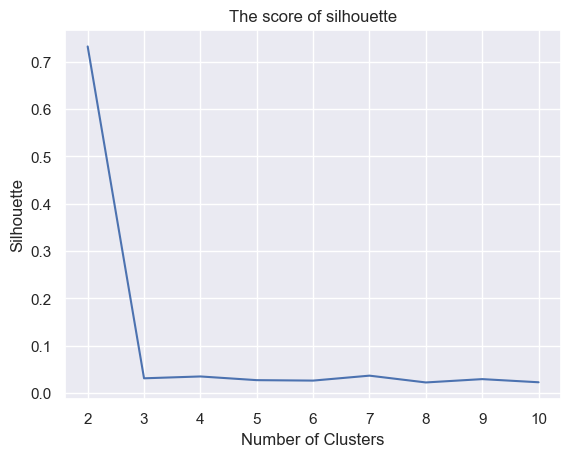

In [47]:
silhouette_list = []    #轮廓系数列表

for i in range(2,11):
    
  kmeans_model = KMeans(n_clusters=i, random_state=42)
  kmeans_model.fit(df_scaled)
  score_ = silhouette_score(df_scaled,kmeans_model.labels_)  
  silhouette_list.append(score_)


sns.set(style='darkgrid')
plt.plot(range(2,11), silhouette_list)
plt.title('The score of silhouette')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette')


In [52]:
kmeans_model = KMeans(n_clusters=2, random_state=42).fit(df_scaled)
print(classification_report(labels_df[0], kmeans_model.labels_, digits = 3))

              precision    recall  f1-score   support

           0      0.200     0.010     0.018       104
           1      0.934     0.997     0.965      1463

    accuracy                          0.932      1567
   macro avg      0.567     0.503     0.491      1567
weighted avg      0.885     0.932     0.902      1567



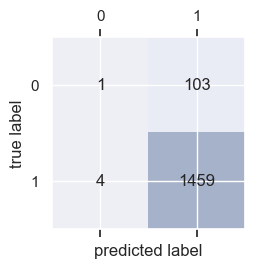

In [50]:
# 混淆矩阵
confmat = confusion_matrix(labels_df[0], kmeans_model.labels_)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()